# Multilayer Perceptron Neural Network képosztályozásra
#### Lakatos Áron

## Szükséges library-k importálása

In [1]:
# Mivel rengeteg random szám generálódik a tensorflow és keras végrehajtások során, így beállítottam
# ezeket egységesre, hogy mindenkinek ugyanaz az eredmény jöjjön ki a végén majd az előadáson.

import os
import numpy as np
from numpy.random import seed
seed(777)
import tensorflow as tf
tf.random.set_seed(444)


import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout

from keras.callbacks import TensorBoard

from time import strftime
import datetime

%load_ext tensorboard

Using TensorFlow backend.


## Adatok beszerzése
#### Bemásoltam a hivatalos információkat a CIFAR10 dataset-ről: The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
#### The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 

In [2]:
from keras.datasets import cifar10

In [3]:
(x_train_all, y_train_all),(x_test, y_test) = cifar10.load_data()

In [4]:
# numpy array-t kapunk meg, tehát már konvertálva vannak a képek array típusra
type(x_train_all)

numpy.ndarray

# Adatok vizualizálása, megismerése

In [5]:
# Hogy meg tudjunk jeleníteni képeket a Jupyterben, kellenek a következő importok:

# Kétféle módon fogjuk megjeleníteni őket,
# Először a display metódussal, majd matplotlibbel

from IPython.display import display
from keras.preprocessing.image import array_to_img

import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
# Most így néz ki az 1. kép a datasetben arrayként:
# Minden pixelt az RGB miatt 3 szám reprezentál

x_train_all[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

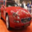

In [7]:
# Kiválasztunk egy tetszőleges képet az adathalmazból (itt az 5 indexű képet), majd megjelenítjük azt

pic = array_to_img(x_train_all[5])
display(pic)

In [8]:
# A képekhez tartozó címkék vannak tárolva az y_train_all változóban

y_train_all.shape

(50000, 1)

In [9]:
# Így kapjuk meg, hogy a megjelenített képhez valóban egy ló címke tartozik.

y_train_all[5][0]

1

In [10]:
# Csak hogy ne számok alapján legyenek a címkék megadva, hanem tudjuk, hogy melyik mit jelöl

label_names = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

In [11]:
label_names[y_train_all[5][0]]

'Car'

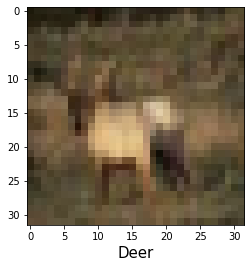

In [12]:
# Vizualizáció matplotlibbel, kiíratva a hozzátartozó címkét

plt.imshow(x_train_all[3])
plt.xlabel(label_names[y_train_all[3][0]], fontsize = 15)
plt.show()

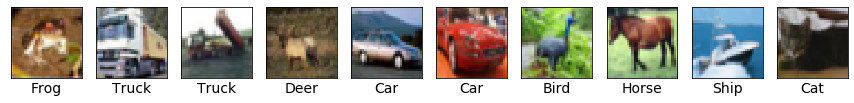

In [13]:
# Az első 10 kép megjelenítésére egy for loop, a címkékkel

plt.figure(figsize=(15,5))

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.yticks([])
    plt.xticks([])
    plt.xlabel(label_names[y_train_all[i][0]], fontsize=14)
    plt.imshow(x_train_all[i])

In [14]:
# 32 pixel a szélesség, 32 a magasság, és 3 a channel-ek, vagyis a színek száma (RGB)

x_train_all[0].shape

(32, 32, 3)

In [15]:
# Hány képet tartalmaz a training halmaz, milyen formátumban?

count_images, x, y, c = x_train_all.shape
print(f'Kepek = {count_images} \t| Szelesseg = {x} \t| Magassag = {y} \t| Channels = {c}')

Kepek = 50000 	| Szelesseg = 32 	| Magassag = 32 	| Channels = 3


# Preprocessing, adatok előkészítése

In [16]:
# Ez például egy pixel RGB értékei 
x_train_all[0][0][0]

array([59, 62, 63], dtype=uint8)

In [17]:
# Normalizáljunk!
# Az RGB skála maximum értéke 255, így ha ezzel leosztjuk a változókat, az értékek 0 és 1 közé fognak kerülni
# Illetve, mivel 255.0-val osztunk, ez át is konvertálja a típust floatra
# Az oka ennek az egésznek, hogy gyorsabbak legyenek a számolások (pl. cost function)
x_train_all, x_test = x_train_all / 255.0, x_test / 255.0

In [18]:
x_train_all[0][0][0]

array([0.23137255, 0.24313725, 0.24705882])

In [19]:
# Képzünk a képekből egy 1 dimenziós array-t, a 3 helyett.
x_train_all = x_train_all.reshape(x_train_all.shape[0], 32*32*3)

In [20]:
x_train_all.shape

(50000, 3072)

In [21]:
x_test = x_test.reshape(len(x_test), 32*32*3)

In [22]:
x_test.shape

(10000, 3072)

## Validation dataset készítése

#### Erre azért van szükség, hogy a teszt adatokat a végén majd valóban csak a legjobb modell kapja meg, addig ezen a validation dataseten hajtjuk végre a szükséges finomításokat

In [23]:
x_val = x_train_all[:10000]
y_val = y_train_all[:10000]
x_val.shape

(10000, 3072)

In [24]:
x_train = x_train_all[10000:]
y_train = y_train_all[10000:]
y_train.shape

(40000, 1)

In [25]:
# Ha gyorsabb feldolgozás miatt 40000-nél kisebb adat kellene, erre létrehozok egy xs datasetet.
# Tensorboardban is gyorsabban tudunk vele vizualizálni.

x_train_xs = x_train[:1000]
y_train_xs = y_train[:1000]

 ## A NN modellek definiálása
 
 #### Két lépésből áll: 
 #### 1. Elkészítjük a modellt, milyen rétegekből álljon, activation függvényeket meghatározzuk stb.
 #### 2. Compile: Megadjuk, hogy a tensorflow milyen módszerrel optimalizálja majd a training során, a költségfüggvény típusát definiáljuk stb.

In [36]:
# Ebben a modellben az input layeren kívül még 4 layer található. 3 Hiddel layer és 1 Output layer.
# A units paraméter jelöli, hogy hány "neuron" található az adott rétegben.
# Az első definiált hidden layerben meg kell adni az inputok számát
# Ez jelen esetben a 32*32*3, azaz 3072.
# Rengeteg fajta activation függvényt lehet használni, én most a relu-t használtam ehhez a feladathoz.
# Az output layerben használt softmax függvény képes valószínűségekké alakítani az outputokat

model_1 = Sequential([
    Dense(units = 128, input_dim = 3072, activation = 'relu', name='m1_hidden1'),
    Dense(units = 64, activation='relu', name='m1_hidden2'),
    Dense(16, activation = 'relu', name='m1_hidden3'),
    Dense(10, activation='softmax', name='m1_output')
])

In [37]:
type(model_1)

tensorflow.python.keras.engine.sequential.Sequential

In [38]:
# categorical cross entropy költségfüggvény, logaritmikus (ilyen esetekben használható, mikor az outputok valószínűségek)
# és Adam optimizer-t használunk (népszerű, kicsi memóriaigény, gyorsabb számítások)
model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [29]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
m1_hidden1 (Dense)           (None, 128)               393344    
_________________________________________________________________
m1_hidden2 (Dense)           (None, 64)                8256      
_________________________________________________________________
m1_hidden3 (Dense)           (None, 16)                1040      
_________________________________________________________________
m1_output (Dense)            (None, 10)                170       
Total params: 402,810
Trainable params: 402,810
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Így jön ki a Total params:

# nem csak a connection-ök vannak a neuronok között, hanem a neuronoknak a bias, amely miatt az actiavtion function eltolódhat
# mondhatjuk, hogy a neuron valójában megegyszik magávan az aktuális actiavtion functionnel
# a tanulás folyamán az activation function változhat (pl. ellaposodhat stb.), ez jelenti a sűlyok változását
# a tanulás során ezeket az egyes activation function-öket változtatja meg a neurális háló (pl. meredekebb lesz, eltolja)

# pl. első rétegben(input): 32*32*3 és az 1. hidden layerben 128 neuron,
# plusz ehhez jön az egyes neuronok bias paramétere: 128


32*32*3*128 + 128 + (128*64 + 64) + (64*16 + 16) + (16*10 + 10)

402810

## Tensorboard beállítása (vizualizáció miatt)

In [31]:
log_dir = "C:\\Users\\36307\\Documents\\notebooks\\NeuralNetML\\tensorboard_logs"
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [32]:
# ez a metódus létrehoz egy mappát a log_dir változóban megadott helyre
# ebben a mappában fogja a tensorboard a logokat raktározni, amikből felépíti a grafikont


def get_tensorboard(model_name):

    folder_name = f'{model_name} at {strftime("%H %M")}'
    dir_paths = os.path.join(log_dir, folder_name)

    try:
        os.makedirs(dir_paths)
    except OSError as err:
        print(err.strerror)
    else:
        print('Successfully created directory')

    return TensorBoard(log_dir=dir_paths)

## Modell illesztése az adatokra

In [39]:
# egy epoch, amikor a teljes dataset egyszer átmegy a training fázison
# a batch, amikor felszabdaljuk a datasetet részekre, és egy iteráció során
# egy ilyen batchen fut le a modell
# így nyilván több iteráció kell, hogy valójában végigmenjen a modell az egész adathalmazon
# a képlet:  Iterációk száma = Training minták száma / Batch méret
#FONTOS: Hogyha újra akarunk futtatni egy modell illesztést, akkor
# onnan fog folytatódni, ahol abbahagyta az utolsó futásnál, tehát ha teljesen
# az elejéről akarjuk trainelni a modellt, akkor újra kell definiálni és futtatni a compile-t is


samples_per_batch = 1000
nr_epochs = 50
model_1.fit(x_train_xs, y_train_xs, 
            batch_size=samples_per_batch, 
            epochs=nr_epochs,
            validation_data = (x_val, y_val),
            callbacks = [get_tensorboard('Model 1')])

Successfully created directory
Train on 1000 samples, validate on 10000 samples
Epoch 1/20
1000/1000 [==============================] - 1s 682us/sample - loss: 2.3653 - accuracy: 0.1030 - val_loss: 2.3159 - val_accuracy: 0.1351
Epoch 2/20
1000/1000 [==============================] - 0s 317us/sample - loss: 2.3045 - accuracy: 0.1430 - val_loss: 2.3236 - val_accuracy: 0.1026
Epoch 3/20
1000/1000 [==============================] - 0s 203us/sample - loss: 2.3184 - accuracy: 0.1140 - val_loss: 2.3012 - val_accuracy: 0.1150
Epoch 4/20
1000/1000 [==============================] - 0s 205us/sample - loss: 2.3002 - accuracy: 0.1210 - val_loss: 2.2990 - val_accuracy: 0.1033
Epoch 5/20
1000/1000 [==============================] - 0s 188us/sample - loss: 2.2945 - accuracy: 0.1110 - val_loss: 2.2933 - val_accuracy: 0.1085
Epoch 6/20
1000/1000 [==============================] - 0s 195us/sample - loss: 2.2876 - accuracy: 0.1150 - val_loss: 2.2947 - val_accuracy: 0.1316
Epoch 7/20
1000/1000 [==========

## Most lehet indítani a Tensorboard-ot:

#### conda promptban kell a következő parancsot kiadni:

#### tensorboard --logdir=IDEKELLAZÚTVONAL A MAPPÁHOZ, AMI A log_dir-BEN VAN
#### pl.: tensorboard --logdir=C:\Users\36307\Documents\notebooks\NeuralNetML\tensorboard_logs
#### Ezután böngészőbe bemásoljátok a http://localhost.... címet, amit kaptok

#### Látni fogtok a felületen grafikonokat, amik mutatják, hogy a tanítás során hogyan alakult a modell pontossága és a költségfüggvény

# Modell fejlesztése (overfitting miatt)

#### Dropout technika: Random figyelmen kívül hagy neuronokat és ezáltal ennek a neuronnak a csatlakozásait is a training során a layerekben, így megelőzi az overfittinget

#### Több layer elé is lehetne rakni dropout layert, a nagyobb biztonság miatt

## 2. Modell egy dropout layerrel

#### Ezt is a nagy training adatra illesztettem itt, pár perc a futásideje, de nyugodtan át lehet írni az _xs datasetekre tesztelés céljából

In [55]:
model_2 = Sequential()
model_2.add(Dropout(0.2, seed=42, input_shape=(3072,)))
model_2.add(Dense(128, activation='relu', name='m2_hidden1'))
model_2.add(Dense(64, activation='relu', name='m2_hidden2'))
model_2.add(Dense(15, activation='relu', name='m2_hidden3'))
model_2.add(Dense(10, activation='softmax', name='m2_output'))

model_2.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])

In [56]:
# ez így nálam 4 percig futott
samples_per_batch = 1000
nr_epochs = 120
model_2.fit(x_train, y_train, batch_size=samples_per_batch, 
            epochs=nr_epochs, validation_data=(x_val, y_val),
            callbacks = [get_tensorboard('Model 2')])

Successfully created directory
Train on 40000 samples, validate on 10000 samples
Epoch 1/120
40000/40000 [==============================] - 2s 53us/sample - loss: 2.2447 - accuracy: 0.1752 - val_loss: 2.1687 - val_accuracy: 0.2169
Epoch 2/120
40000/40000 [==============================] - 2s 40us/sample - loss: 2.1262 - accuracy: 0.2253 - val_loss: 2.0742 - val_accuracy: 0.2476
Epoch 3/120
40000/40000 [==============================] - 2s 41us/sample - loss: 2.0397 - accuracy: 0.2677 - val_loss: 1.9809 - val_accuracy: 0.2997
Epoch 4/120
40000/40000 [==============================] - 2s 41us/sample - loss: 1.9546 - accuracy: 0.3019 - val_loss: 1.8953 - val_accuracy: 0.3158
Epoch 5/120
40000/40000 [==============================] - 2s 41us/sample - loss: 1.8869 - accuracy: 0.3177 - val_loss: 1.8389 - val_accuracy: 0.3350
Epoch 6/120
40000/40000 [==============================] - 2s 41us/sample - loss: 1.8475 - accuracy: 0.3298 - val_loss: 1.8072 - val_accuracy: 0.3416
Epoch 7/120
40000/4

Epoch 55/120
40000/40000 [==============================] - 2s 59us/sample - loss: 1.4468 - accuracy: 0.4811 - val_loss: 1.4485 - val_accuracy: 0.4841
Epoch 56/120
40000/40000 [==============================] - 2s 58us/sample - loss: 1.4373 - accuracy: 0.4859 - val_loss: 1.4698 - val_accuracy: 0.4734
Epoch 57/120
40000/40000 [==============================] - 2s 58us/sample - loss: 1.4364 - accuracy: 0.4868 - val_loss: 1.4788 - val_accuracy: 0.4645
Epoch 58/120
40000/40000 [==============================] - 2s 57us/sample - loss: 1.4402 - accuracy: 0.4830 - val_loss: 1.4485 - val_accuracy: 0.4820
Epoch 59/120
40000/40000 [==============================] - 2s 58us/sample - loss: 1.4268 - accuracy: 0.4896 - val_loss: 1.4567 - val_accuracy: 0.4808
Epoch 60/120
40000/40000 [==============================] - 2s 61us/sample - loss: 1.4297 - accuracy: 0.4879 - val_loss: 1.4723 - val_accuracy: 0.4756
Epoch 61/120
40000/40000 [==============================] - 2s 60us/sample - loss: 1.4369 - ac

## Tensorboard kép:

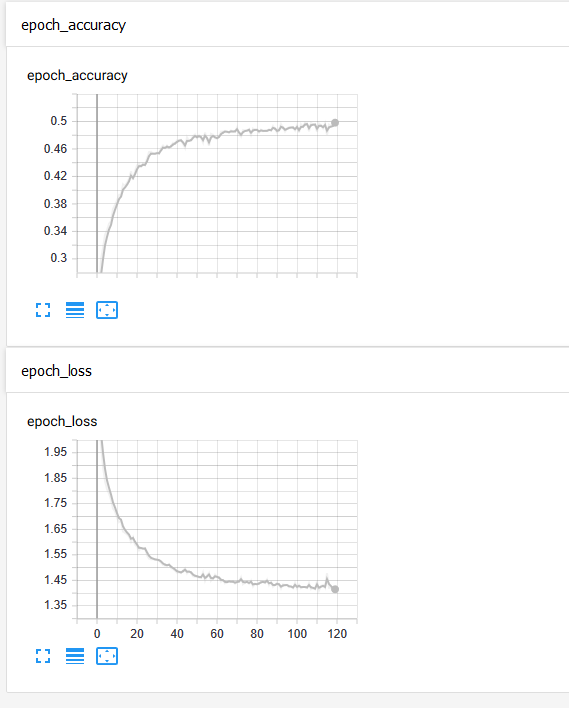

## 3. modell (két dropout layerrel)
#### Ezt már a rendes nagy training set-re illesztettem

In [44]:
model_3 = Sequential()
model_3.add(Dropout(0.2, seed=42, input_shape=(3072,)))
model_3.add(Dense(128, activation='relu', name='m3_hidden1'))
model_3.add(Dropout(0.25, seed=42))
model_3.add(Dense(64, activation='relu', name='m3_hidden2'))
model_3.add(Dense(15, activation='relu', name='m3_hidden3'))
model_3.add(Dense(10, activation='softmax', name='m3_output'))

model_3.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])

In [45]:
samples_per_batch = 1000
nr_epochs = 70
model_3.fit(x_train, y_train, batch_size=samples_per_batch, epochs=nr_epochs, 
            verbose=1, validation_data=(x_val, y_val), callbacks = [get_tensorboard('Model 3')])

Successfully created directory
Train on 40000 samples, validate on 10000 samples
Epoch 1/70
40000/40000 [==============================] - 2s 57us/sample - loss: 2.2491 - accuracy: 0.1411 - val_loss: 2.1171 - val_accuracy: 0.1792
Epoch 2/70
40000/40000 [==============================] - 2s 44us/sample - loss: 2.0959 - accuracy: 0.1928 - val_loss: 2.0281 - val_accuracy: 0.2216
Epoch 3/70
40000/40000 [==============================] - 2s 43us/sample - loss: 2.0275 - accuracy: 0.2375 - val_loss: 1.9539 - val_accuracy: 0.2901
Epoch 4/70
40000/40000 [==============================] - 2s 43us/sample - loss: 1.9665 - accuracy: 0.2738 - val_loss: 1.8903 - val_accuracy: 0.3155
Epoch 5/70
40000/40000 [==============================] - 2s 43us/sample - loss: 1.9156 - accuracy: 0.2998 - val_loss: 1.8362 - val_accuracy: 0.3450
Epoch 6/70
40000/40000 [==============================] - 2s 43us/sample - loss: 1.8675 - accuracy: 0.3232 - val_loss: 1.7979 - val_accuracy: 0.3557
Epoch 7/70
40000/40000 [=

## Lescreeneltem a Tensorboardot erről a futásról, látszik, hogy szépen alakult a modell pontossága, illetve a költségfüggvény is csökkent

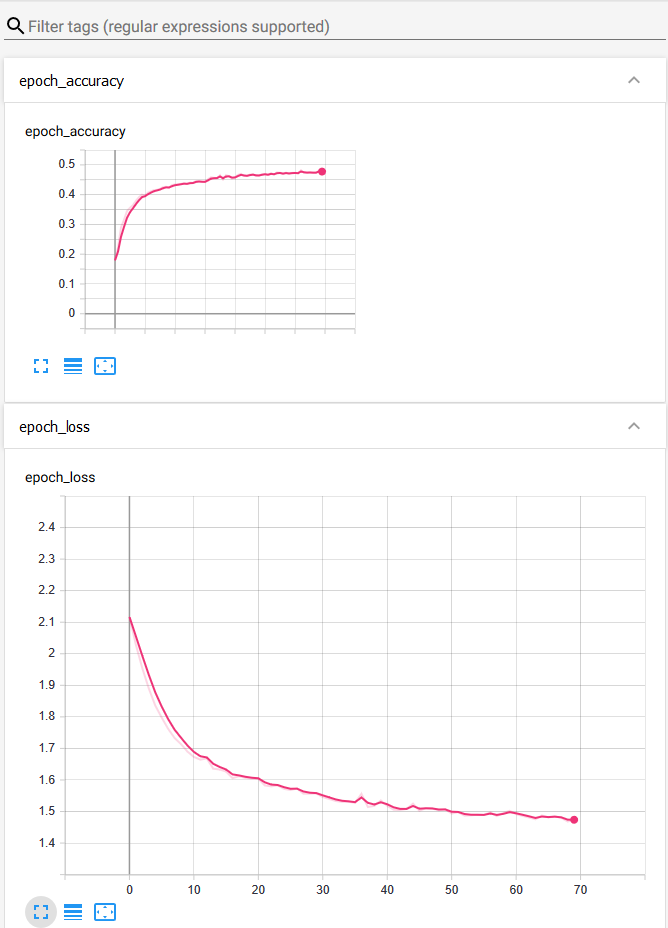

# Prediction

In [49]:
#az első kép a val. datasetből
# látszik, hogy 1 dimenziós, hozzá kell adnunk még 1 dimenziót
x_val[3].shape

(3072,)

In [50]:
test = np.expand_dims(x_val[3], axis = 0)
test.shape

(1, 3072)

In [57]:
# megkapjuk a különböző kategóriák valószínűségeit
model_2.predict(test)

array([[0.05036019, 0.06157459, 0.09461053, 0.04866208, 0.34632766,
        0.06394461, 0.25659165, 0.04968238, 0.01881503, 0.00943123]],
      dtype=float32)

In [58]:
# Így megkapjuk, hogy melyik osztályhoz tartozik a legnagyobb valószínűség
model_2.predict_classes(test)

array([4], dtype=int64)

In [60]:
# jó a jóslat?
# igen
y_val[3]

array([4], dtype=uint8)

In [61]:
for number in range(10):
    test_img = np.expand_dims(x_val[number], axis=0)
    predicted_val = model_2.predict_classes(test_img)[0]
    print(f'Actual value: {y_val[number][0]} vs. predicted: {predicted_val}')

Actual value: 6 vs. predicted: 6
Actual value: 9 vs. predicted: 1
Actual value: 9 vs. predicted: 9
Actual value: 4 vs. predicted: 4
Actual value: 1 vs. predicted: 8
Actual value: 1 vs. predicted: 9
Actual value: 2 vs. predicted: 2
Actual value: 7 vs. predicted: 7
Actual value: 8 vs. predicted: 8
Actual value: 3 vs. predicted: 1


# Kiértékelés

In [62]:
model_2.metrics_names

['loss', 'accuracy']

In [63]:
test_loss, test_accuracy = model_2.evaluate(x_test, y_test)
print(f'Test loss is {test_loss:0.3} and test accuracy is {test_accuracy:0.1%}')

10000/10000 [==============================] - 1s 73us/sample - loss: 1.4162 - accuracy: 0.4946
Test loss is 1.42 and test accuracy is 49.5%


### Látszik, hogy a teszt adatokra is egészen jó, 49.5% -os pontossággal jósol a 2. modell.

## Confusion matrix elkészítése a teszt adatokra

In [64]:
from sklearn.metrics import confusion_matrix


predictions = model_2.predict_classes(x_test)
conf_matrix = confusion_matrix(y_true=y_test, y_pred=predictions)

In [65]:
nr_rows = conf_matrix.shape[0]
nr_cols = conf_matrix.shape[1]

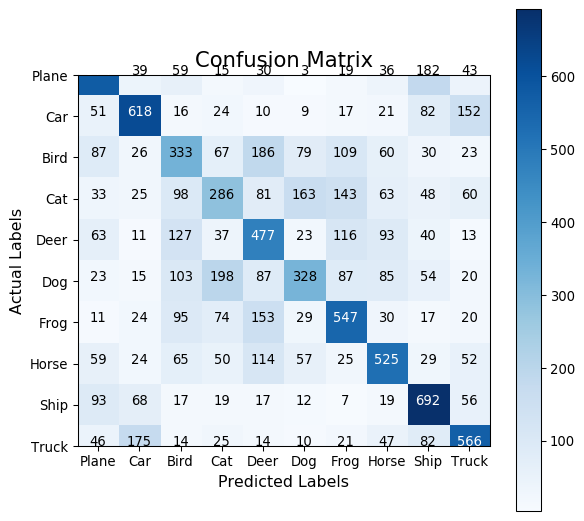

In [75]:
LABEL_NAMES = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
import itertools


plt.figure(figsize=(7,7), dpi=95)
plt.imshow(conf_matrix, cmap=plt.cm.Blues)

plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Labels', fontsize=12)
plt.xlabel('Predicted Labels', fontsize=12)

tick_marks = np.arange(10)
plt.yticks(tick_marks, LABEL_NAMES)
plt.xticks(tick_marks, LABEL_NAMES)

plt.colorbar()

for i, j in itertools.product(range(nr_rows), range(nr_cols)):
    plt.text(j, i, conf_matrix[i, j], horizontalalignment='center',
            color='white' if conf_matrix[i, j] > conf_matrix.max()/2 else 'black')
    

plt.show()

In [76]:
# True positive-ak
np.diag(conf_matrix)

array([574, 618, 333, 286, 477, 328, 547, 525, 692, 566], dtype=int64)

In [77]:
# True pos / True pos+False Neg(sorok)
recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
recall

array([0.574, 0.618, 0.333, 0.286, 0.477, 0.328, 0.547, 0.525, 0.692,
       0.566])

In [78]:
# True pos / True pos+False Pos(oszlopok)
precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
precision

array([0.55192308, 0.60292683, 0.3592233 , 0.35974843, 0.40804106,
       0.46002805, 0.50137489, 0.53626149, 0.55095541, 0.56318408])

In [79]:
avg_recall = np.mean(recall)
print(f'Model 2 recall: {avg_recall:.2%}')

avg_precision = np.mean(precision)
print(f'Model 2 precision: {avg_precision:.2%}')

f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall)
print(f'Model 2 f score: {f1_score:.2%}')

Model 2 recall: 49.46%
Model 2 precision: 48.94%
Model 2 f score: 49.20%


## Nyilván ezeken az értékeken sokat lehetne javítani egy sokkal nagyobb computer visionra kitalált neurális hálóval, vagy még nagyobb teszt adat mennyiséggel, de egy ilyen egyszerű modellnek ez tökéletes eredmény figyelembe véve, hogy 10 kategóriánál eltalálja a felét.

#### Lakatos Áron